!sudo apt install tesseract-ocr

In [1]:
from keras.layers import Dense, Input, Activation
from keras.layers.normalization import BatchNormalization
import efficientnet.keras as efn 
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.models import model_from_json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os
import darknet

from keras.preprocessing import image
#mport pytesseract

Using TensorFlow backend.


In [2]:
def get_img(img_dir):
    try:
        img=cv2.imreade(img_dir)
    except:
        print("wrong dir!")
    return img

In [3]:
def superresolution(org_img_dir):
    
    cv2.imwrite('high_res_img.jpg',image_crop)
    return 'high_res_img.jpg'

In [4]:
def crop_img(img_dir):  
    #다크넷에 cfg라는 모델층과 기존 학습된 weight를 연결
    net = darknet.load_net_custom("./yolov4.cfg".encode('utf-8'),"./yolov4.weights".encode('utf-8'), 0,1)
    # 데이터도 연결 / coco.data안에는 80개의 클래스를 알아볼수있는 이름들이 있는데 그중에 car도 잇음
    meta = darknet.load_meta("./coco.data".encode('utf-8'))
    a = cv2.imread(img_dir)

    #디텍션하기
    detections = darknet.detect_image(net, meta, a, thresh=0.9)

    x1 = int(round((detections[0][2][0]) - (detections[0][2][2]/2.0))) # top left x1 
    y1 = int(round((detections[0][2][1]) - (detections[0][2][3]/2.0))) # top left xy 
    x2 = int(round((detections[0][2][0]) + (detections[0][2][2]/2.0))) # bottom right x2 
    y2 = int(round((detections[0][2][1]) + (detections[0][2][3]/2.0))) # bottom right y2 
    image_crop = a[y1:y2,x1:x2]              
    cv2.imwrite('cropimg.jpg',image_crop)
    
    print("original img")
    img = image.load_img(img_dir)
    plt.figure()
    plt.imshow(img)
    plt.show()
    
    return 'cropimg.jpg'

In [5]:
def classifier(img_dir,model):
    
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    
    img = image.load_img(img_dir, target_size=(240, 240))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
    
    images=np.vstack([img_tensor])
    pred=model.predict(images)
    
    print("croped img")
    plt.figure()
    plt.imshow(img)
    plt.show()
    
    return pred

In [6]:
def OCR(img_dir):
    img_ori = cv2.imread(img_dir)
    height, width, channel = img_ori.shape
    gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    imgTopHat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, structuringElement)

    imgGrayscalePlusTopHat = cv2.add(gray, imgTopHat)
    gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)
    
    img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0) # denoise

    img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
    )
    
    contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE
    )

    temp_result = np.zeros((height, width, channel), dtype=np.uint8)

    cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

    temp_result = np.zeros((height, width, channel), dtype=np.uint8)

    contours_dict = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) 
        cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)

        # insert to dict
        contours_dict.append({
            'contour': contour,
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'cx': x + (w / 2),
            'cy': y + (h / 2)
        })
        
    MIN_AREA = 80
    MIN_WIDTH, MIN_HEIGHT = 2, 8
    MIN_RATIO, MAX_RATIO = 0.25, 1.0

    possible_contours = []

    cnt = 0
    for d in contours_dict:
        area = d['w'] * d['h']
        ratio = d['w'] / d['h']

        if area > MIN_AREA \
        and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            d['idx'] = cnt
            cnt += 1
            possible_contours.append(d)

    # visualize possible contours
    temp_result = np.zeros((height, width, channel), dtype=np.uint8)

    for d in possible_contours:
    #     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
    
    MAX_DIAG_MULTIPLYER = 5 # 5  contour 끼리의 거리
    MAX_ANGLE_DIFF = 12.0 # 12.0 contour 끼리의 대각선 각도
    MAX_AREA_DIFF = 0.5 # 0.5 contour 끼리의 면전
    MAX_WIDTH_DIFF = 0.8 #
    MAX_HEIGHT_DIFF = 0.2 
    MIN_N_MATCHED = 3 # 3 최소 매치 갯수

    def find_chars(contour_list):
        matched_result_idx = []

        for d1 in contour_list:
            matched_contours_idx = []
            for d2 in contour_list:
                if d1['idx'] == d2['idx']:
                    continue

                dx = abs(d1['cx'] - d2['cx'])
                dy = abs(d1['cy'] - d2['cy'])

                diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2) # d1의 박스 대각선

                distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']])) # 두 박스의 대각선   
                if dx == 0:
                    angle_diff = 90
                else:
                    angle_diff = np.degrees(np.arctan(dy / dx))
                area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
                width_diff = abs(d1['w'] - d2['w']) / d1['w']
                height_diff = abs(d1['h'] - d2['h']) / d1['h']

                if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
                and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
                and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                    matched_contours_idx.append(d2['idx'])

            # append this contour
            matched_contours_idx.append(d1['idx'])

            if len(matched_contours_idx) < MIN_N_MATCHED:
                continue

            matched_result_idx.append(matched_contours_idx)

            unmatched_contour_idx = []
            for d4 in contour_list:
                if d4['idx'] not in matched_contours_idx:
                    unmatched_contour_idx.append(d4['idx'])

            unmatched_contour = np.take(possible_contours, unmatched_contour_idx)

            # recursive
            recursive_contour_list = find_chars(unmatched_contour)

            for idx in recursive_contour_list:
                matched_result_idx.append(idx)

            break

        return matched_result_idx

    result_idx = find_chars(possible_contours)

    matched_result = []
    for idx_list in result_idx:
        matched_result.append(np.take(possible_contours, idx_list))

    # visualize possible contours
    temp_result = np.zeros((height, width, channel), dtype=np.uint8)

    for r in matched_result:
        for d in r:
    #         cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
            cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
    
    PLATE_WIDTH_PADDING = 1.3 # 1.3
    PLATE_HEIGHT_PADDING = 1.5 # 1.5
    MIN_PLATE_RATIO = 3
    MAX_PLATE_RATIO = 10

    plate_imgs = []
    plate_infos = []

    for i, matched_chars in enumerate(matched_result):
        sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

        plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
        plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

        plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

        sum_height = 0
        for d in sorted_chars:
            sum_height += d['h']

        plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

        triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
        triangle_hypotenus = np.linalg.norm(
            np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
            np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
        )

        angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

        rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

        img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

        img_cropped = cv2.getRectSubPix(
            img_rotated, 
            patchSize=(int(plate_width), int(plate_height)), 
            center=(int(plate_cx), int(plate_cy))
        )

        if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
            continue

        plate_imgs.append(img_cropped)
        plate_infos.append({
            'x': int(plate_cx - plate_width / 2),
            'y': int(plate_cy - plate_height / 2),
            'w': int(plate_width),
            'h': int(plate_height)
        })
    longest_idx, longest_text = -1, 0
    plate_chars = []

    for i, plate_img in enumerate(plate_imgs):
        plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
        _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        # find contours again (same as above)
        contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

        plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
        plate_max_x, plate_max_y = 0, 0

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            area = w * h
            ratio = w / h

            if area > MIN_AREA \
            and w > MIN_WIDTH and h > MIN_HEIGHT \
            and MIN_RATIO < ratio < MAX_RATIO:
                if x < plate_min_x:
                    plate_min_x = x
                if y < plate_min_y:
                    plate_min_y = y
                if x + w > plate_max_x:
                    plate_max_x = x + w
                if y + h > plate_max_y:
                    plate_max_y = y + h

        img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]

        img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
        _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
        #여백을

        chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0') ## legacy 모델 건들지 말것
        #chars = pytesseract.image_to_string(img_result, lang='kor')
        #chars = pytesseract.image_to_string(img_result)


        result_chars = ''
        has_digit = False
        for c in chars:
            if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
                if c.isdigit():
                    has_digit = True
                result_chars += c

        #print(f"{i}th : {result_chars}")
        plate_chars.append(result_chars)

        if has_digit and len(result_chars) > longest_text:
            longest_idx = i
            return plate_chars[longest_idx]
        

In [6]:
def returnCarname(output_prob):
    predict_ind=np.argmax(output_prob)
    #print(predict_ind)
    class_name={'Chevrolet_넥스트스파크': 0, 'Chevrolet_말리부': 1, 'Chevrolet_볼트': 2, 'Chevrolet_볼트 EV': 3, 'Chevrolet_스파크': 4, 'Chevrolet_임팔라': 5, 'Chevrolet_캡티바': 6,
                'Chevrolet_크루즈': 7, 'Chevrolet_트랙스': 8, 'GM Daewoo_라세티': 9, 'GM Daewoo_알페온': 10, 'Hyundai_G80 스포츠': 11, 'Hyundai_G90': 12, 'Hyundai_KONA 1.6T': 13,
                'Hyundai_i30': 14, 'Hyundai_그랜저': 15, 'Hyundai_그랜저 HG240': 16, 'Hyundai_그랜저 IG': 17, 'Hyundai_더뉴그랜드스타렉스': 18, 'Hyundai_더뉴아반떼 AD': 19, 
                'Hyundai_맥스크루즈': 20, 'Hyundai_벨로스터': 21, 'Hyundai_소나타': 22, 'Hyundai_소나타 LF': 23, 'Hyundai_소나타 LPI': 24, 'Hyundai_소나타 NF': 25, 'Hyundai_소나타 YF': 26, 
                'Hyundai_소나타 뉴라이즈': 27, 'Hyundai_소나타 하이브리드': 28, 'Hyundai_스타렉스': 29, 'Hyundai_싼타페': 30, 'Hyundai_아반떼 AD': 31, 'Hyundai_아반떼 MD': 32, 'Hyundai_아반떼 XD': 33,
                'Hyundai_아슬란': 34, 'Hyundai_아이오닉 일렉트릭': 35, 'Hyundai_아이오닉 하이브리드': 36, 'Hyundai_에쿠스': 37, 'Hyundai_엑센트': 38, 'Hyundai_제네시스 G380': 39, 'Hyundai_제네시스 G70': 40,
                'Hyundai_제네시스 G80': 41, 'Hyundai_투싼': 42, 'Hyundai_투싼 1.7D': 43, 'Hyundai_팰리세이드': 44, 'Kia_K3': 45, 'Kia_K5': 46, 'Kia_K7': 47, 'Kia_K9': 48, 'Kia_니로 하이브리드': 49, 'Kia_더뉴레이': 50,
                'Kia_레이': 51, 'Kia_모닝': 52, 'Kia_모하비': 53, 'Kia_스토닉': 54, 'Kia_스팅어': 55, 'Kia_스포티지': 56, 'Kia_스포티지 R': 57, 'Kia_스포티지 더볼드': 58, 'Kia_쏘렌토': 59, 'Kia_쏘울': 60,
                'Kia_쏘울 EV': 61, 'Kia_올뉴K3': 62, 'Kia_올뉴모닝': 63, 'Kia_카니발': 64, 'Kia_카니발 11인승': 65, 'Kia_카니발 하이리무진': 66, 'Kia_카렌스': 67, 'Kia_포르테': 68, 'Kia_프라이드 해치백': 69,
                'Renault Samsung_QM3': 70, 'Renault Samsung_QM6': 71, 'Renault Samsung_SM3': 72, 'Renault Samsung_SM5': 73, 'Renault Samsung_SM520': 74, 'Renault Samsung_SM6': 75, 'Renault Samsung_SM7': 76,
                'Renault Samsung_클리오': 77, 'Ssangyong_G4 렉스턴': 78, 'Ssangyong_코란도 C': 79, 'Ssangyong_코란도 스포츠': 80, 'Ssangyong_코란도 투리스모': 81, 'Ssangyong_티볼리': 82, 'Ssangyong_티볼리 에어': 83}
    class_name_lst=[None]*len(class_name)
    for model,inx in class_name.items():
        class_name_lst[inx]=model
    return class_name_lst[predict_ind]
































In [7]:
def findcarmodel(org_img_dir,model):
    crop_img_dir=crop_img(org_img_dir)
    model_ouput=classifier(crop_img_dir,model)
    #carnum_ouput=OCR(crop_img_dir) # car_num(str) or None
    return returnCarname(model_ouput) 

In [8]:
classifier_model_dir="/home/pirl/Project/AiHubCarDataSet/20_06_02_200epoc_effimodel.h5"
model=load_model(classifier_model_dir)



----------------------------------------------------------------------------------------------------
orgianal model : 쉐보레 크루즈
----------------------------------------------------------------------------------------------------
original img


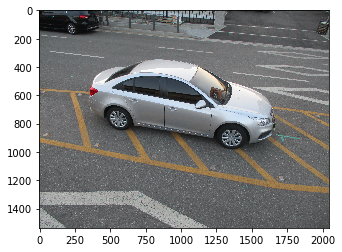

croped img


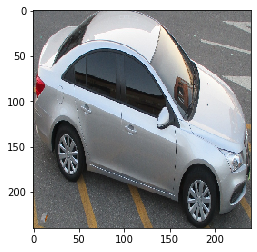

predict model : Chevrolet_크루즈


----------------------------------------------------------------------------------------------------
orgianal model : 기아 카렌스
----------------------------------------------------------------------------------------------------
original img


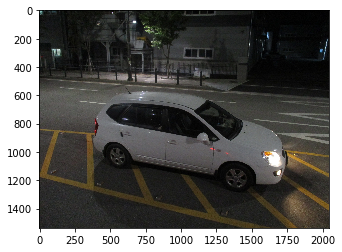

croped img


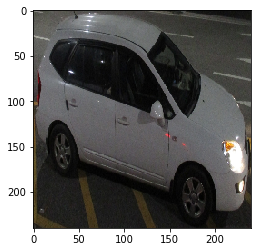

predict model : Kia_카렌스


----------------------------------------------------------------------------------------------------
orgianal model : 현대 G80스포츠
----------------------------------------------------------------------------------------------------
original img


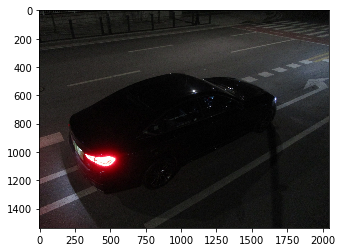

croped img


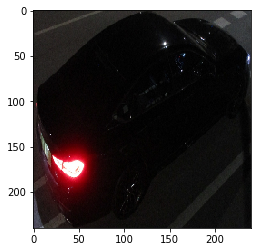

predict model : Hyundai_G80 스포츠


----------------------------------------------------------------------------------------------------
orgianal model : 기아 K9
----------------------------------------------------------------------------------------------------
original img


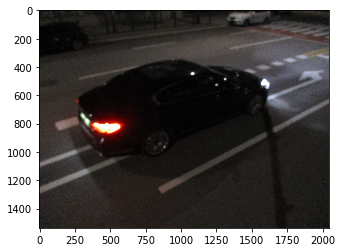

croped img


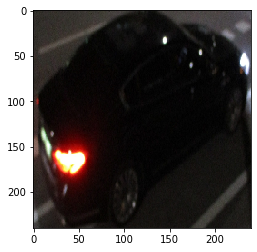

predict model : Kia_K9




In [9]:
org_img_dir_lst=["/home/pirl/Project/AiHubCarDataSet/Chevrolet/Chevrolet/Chevrolet/크루즈/2016/16시대/H75/쉐보레_크루즈_2016_16시대_H75_V45.JPG",
                "/home/pirl/Project/AiHubCarDataSet/Kia/Kia/Kia/카렌스/2012/18시대/H75/기아_카렌스_2012_18시대_H75_V30.JPG",
                "/home/pirl/Project/AiHubCarDataSet/Hyundai/Hyundai/Hyundai/G80 스포츠/2017/18시대/H135/현대_G80스포츠_2017_18시대_H135_V45_(1).JPG",
                "/home/pirl/Project/AiHubCarDataSet/Kia/Kia/Kia/K9/2013/18시대/H135/기아_K9_2013_18시대_H135_V45.JPG"]

for org_img_dir in org_img_dir_lst:
    modelname=" ".join((org_img_dir.split("/"))[-1].split(" ")[0].split("_")[:2])
    print("-"*100)
    print(f"orgianal model : {modelname}")
    print("-"*100)
    print(f"predict model : {findcarmodel(org_img_dir,model)}")
    print("="*100,"\n"*2)
